In [115]:
# Allow display of images
from IPython.display import display, Image

# Import the required modules
import numpy as np
import matplotlib.pyplot as plt
import glob

import pandas as pd
import seaborn as sns

# Tools from brainsignal library
import os
import sys
path=r'C:\Users\Hamon\Documents\Stage\brainsignal'
sys.path.append(path)
import brainsignal.datageneration as dg
import brainsignal.datanalysis as da
import brainsignal.HRVanalysis as ha

# This makes the plots appear inside the notebook
%matplotlib inline


# data science
from matplotlib.patches import Ellipse

# signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz
#import pywt

# misc
import warnings

### Load data

We load the data from the txt files

In [116]:
rep='../../data/'
patientdir='ID_2'

file=glob.glob(rep+patientdir+'/WAVE_ABP.txt', recursive=True)[0]

data=pd.read_csv(file,header=None, decimal=',', delimiter='\n')
data_array=np.array(data.values)
ABP_signal=data_array.transpose()[0]

In [117]:
fs=200
ABP_time=np.arange(len(ABP_signal))/fs

### Visualisation

Let take a look to the data. We chose arbitrarily a given time window [t1 - t2] hours.

(0.0, 250.0)

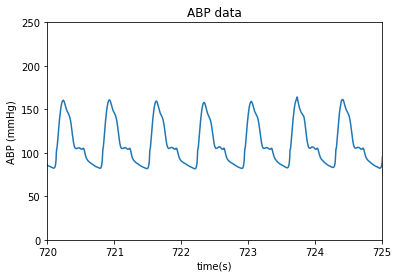

In [118]:
t1=720 #second
t2= 725 #second 
time=0.2 #hour
plt.figure()
plt.plot(ABP_time,ABP_signal)

plt.title('ABP data')
plt.ylabel('ABP (mmHg)')
plt.xlabel('time(s)')

plt.xlim([time*60*60,time*60*60+5])
plt.ylim([0,250])

# Peak detection

We would like to calculate the time interval between two cardiac pulsations which is called the RR interval in the litterature. Indeed this RR interval is used in a lot of features calculation needed to describe the signal. The RR interval can be determinated calculating the time difference between two successive peaks. That is why we need an effective function to detect peaks.

We will try several technics to detect the peaks in the ABP signal.

First, let's chose a time window [start, start+duration] to study the signal in a focused interval.

In [119]:
#Time selection 
start=6000 #cond departure time 
duration=30 #second

indices=da.indexseq(start, duration, ABP_time)

## First method

This first method uses template matching, we will compare our signal with a sinus that we will drag on the selected time window.

We use the function that we have written in the HRVanalysis library. To begin, we chose the sinus frequency equal to 1 Hz (default parameter) and a similarity threshold of 0.6.

- Plot of the similarity function used :

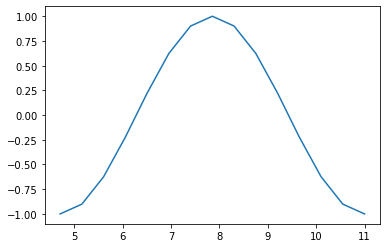

In [120]:
t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
qrs_filter = np.sin(t)
plt.plot(t,qrs_filter)

- Peak detection :

In [121]:
#peak detection 
signal_peaks,time_peaks,peaks_index, similarity=ha.detect_peaks(ABP_signal[indices],ABP_time[indices],threshold=0.6)

After detecting peaks with the functions we represent peaks founded with red stars.

Text(0.5, 0, 'time(s)')

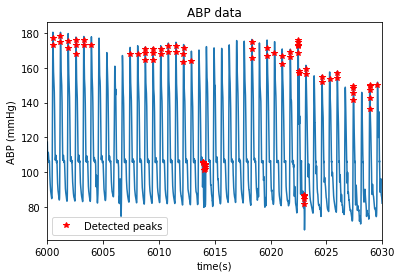

In [122]:
#visualisation of the signal with peaks detected
plt.plot(ABP_time[indices],ABP_signal[indices])
plt.plot(time_peaks, signal_peaks, 'r*', label='Detected peaks')
plt.xlim([start,start+duration])

plt.legend()
plt.title('ABP data')
plt.ylabel('ABP (mmHg)')
plt.xlabel('time(s)')

We can see that it does not work as expected. Maybe because the similarity function and our signal does not have the same frequency.

- We try now to change the frequency and adapt it to heart rate to compare if it is better. To calculate the heart rate we plot the periodogram to detect frequency peak corresponding to heart rate.

(0.0, 5.0)

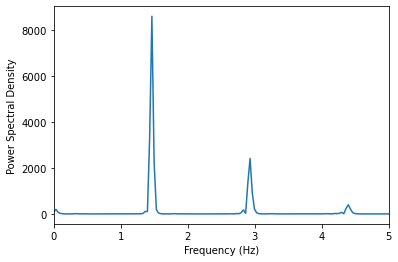

In [123]:
# periodogram 
frequency,power=signal.periodogram(ABP_signal[indices],fs,window='hanning',nfft=None ,scaling='density')

#plot 
plt.plot(frequency,power)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.xlim([0,5])

We can see a frenquency peak around 1.5 Hz corresponding to heart rate. We now use the function in datanalysis library to get the frequency value of the peak between 1 and 2 Hz.

In [124]:
hr,index_hr=da.searchpeak(power,frequency,fmin=1,fmax=2)
print('Heart rate (Hz)=',hr)

Heart rate (Hz)= 1.3597734088637121


Text(0.5, 0, 'time(s)')

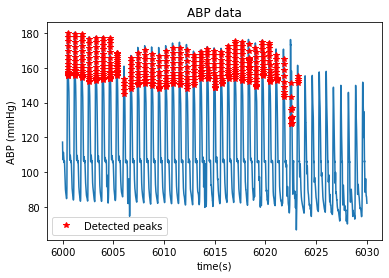

In [125]:
#peak detection in ABP signal
signal_peaks,time_peaks,peaks_index, similarity=ha.detect_peaks(ABP_signal[indices],ABP_time[indices],frequency=hr,threshold=0.6)

#visualisation of the signal with peaks detected
plt.plot(ABP_time[indices],ABP_signal[indices])
plt.plot(time_peaks, signal_peaks, 'r*',label='Detected peaks')

plt.legend()
plt.title('ABP data')
plt.ylabel('ABP (mmHg)')
plt.xlabel('time(s)')

We can see now that it work better with comparison of the signal with a sinus at the same frequency. But the method does not detect peaks with lower  amplitude.

- Let's try for other time period

We repeat the same steps. 

Text(0.5, 0, 'time(s)')

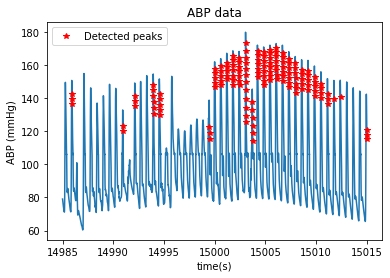

In [155]:
#Time selection 
start=14985 #cond departure time 
duration=30 #second

indices=da.indexseq(start, duration, ABP_time)

# periodogram 
frequency,power=signal.periodogram(ABP_signal[indices],fs,window='hanning',nfft=None ,scaling='density')

#Heart rate 
hr,index_hr=da.searchpeak(power,frequency,fmin=1,fmax=2)

#peak detection 
signal_peaks,time_peaks,peaks_index, similarity=ha.detect_peaks(ABP_signal[indices],ABP_time[indices],frequency=hr,threshold=0.6)

#visualisation of the signal with peaks detected
plt.plot(ABP_time[indices],ABP_signal[indices])
plt.plot(time_peaks, signal_peaks, 'r*',label='Detected peaks')

plt.legend()
plt.title('ABP data')
plt.ylabel('ABP (mmHg)')
plt.xlabel('time(s)')

We can see that it is better with heart rate consideration but the function still not detect peaks with lower amplitude than others. We can see also that this technic detect peaks several time so we need to group peaks which are closer.

- Let's compare peaks founded with the similarity

Text(0, 0.5, 'Similarity (normalized)')

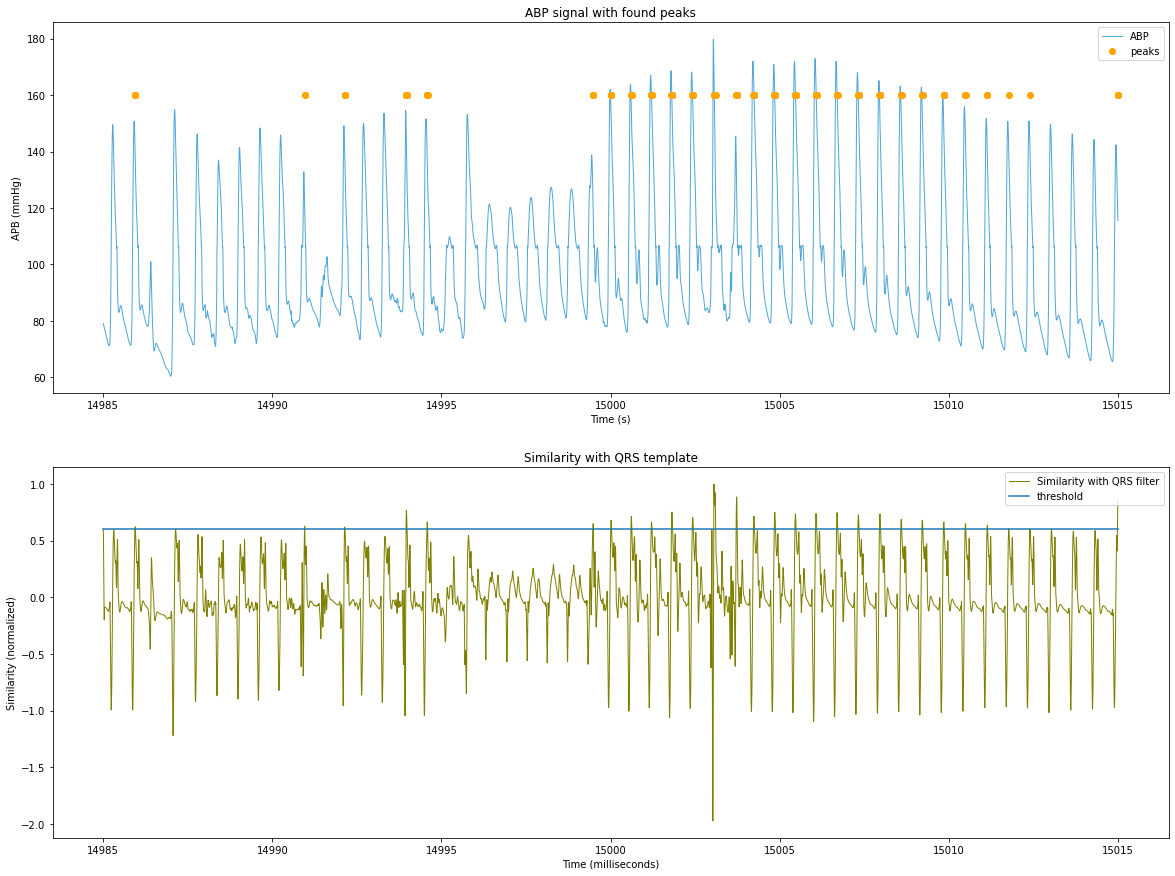

In [156]:
plt.figure(figsize=(20, 15))
#plot signal with founded peaks
plt.subplot(211)
plt.title("ABP signal with found peaks")
plt.plot(ABP_time[indices], ABP_signal[indices], label="ABP", color="#51A6D8", linewidth=1)
plt.plot(time_peaks, np.repeat(160, time_peaks.shape[0]), label="peaks", color="orange", marker="o", linestyle="None")
plt.legend(loc="upper right")
plt.xlabel("Time (s)")
plt.ylabel("APB (mmHg)")
 
# plot similarity
plt.subplot(212)
plt.title('Similarity with QRS template')
plt.plot(ABP_time[indices], similarity, label="Similarity with QRS filter", color="olive", linewidth=1)
plt.plot(dg.generate_time(30,1,start),np.ones(31)*0.6, label='threshold')
plt.legend(loc="upper right")
plt.xlabel("Time (milliseconds)")
plt.ylabel("Similarity (normalized)")

We can see that only peaks with a similarity with a sinus higher than 0.6 are detected. The function does not work for a peak with not close of the similarity function shape.

- Let's group similar peaks 

We use the function group_peaks from HRVanalysis library and we choose to group peaks distant from less than 0.5 seconds. Peaks are grouped and we determine the median of values grouped so we have only one time value for each peak.

time grouped peaks [14985.9375 14990.95   14992.1375 14993.965  14994.5775 14999.4825
 15000.0125 15000.6125 15001.2125 15001.8125 15002.4275 15003.075
 15003.9825 15004.855  15005.465  15006.075  15006.6975 15007.3275
 15007.9625 15008.5925 15009.2175 15009.8525 15010.49   15011.1375
 15014.9925]


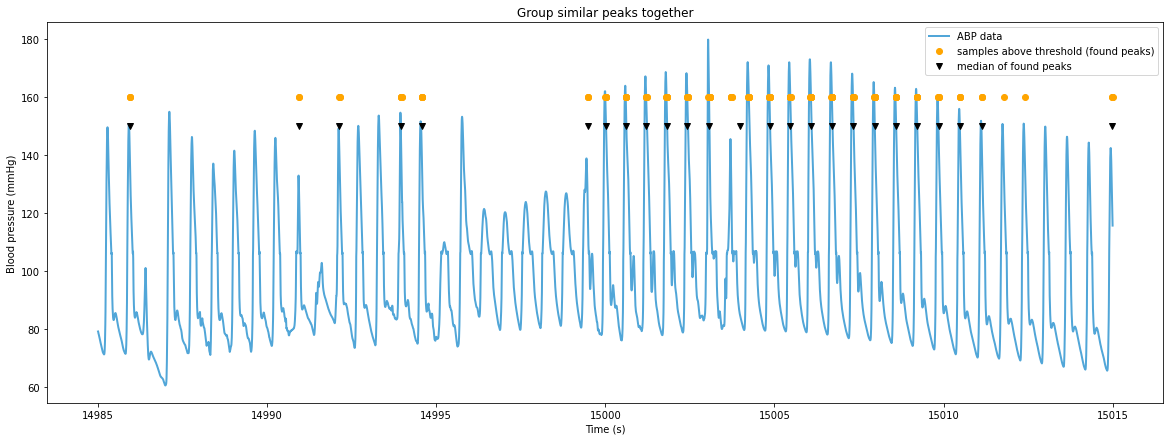

In [157]:
# group peaks
t_grouped_peak = ha.group_peaks(time_peaks,threshold=0.5) #time of grouped peaks 

print('time grouped peaks', t_grouped_peak)

# plot peaks
plt.figure(figsize=(20, 7))
plt.title("Group similar peaks together")
plt.plot(ABP_time[indices], ABP_signal[indices], label="ABP data", color="#51A6D8", linewidth=2)
plt.plot(time_peaks, np.repeat(160, time_peaks.shape[0]),label="samples above threshold (found peaks)", color="orange", marker="o", linestyle="None")
plt.plot(t_grouped_peak, np.repeat(150, t_grouped_peak.shape[0]), label="median of found peaks", color="k", marker="v", linestyle="None")
plt.legend(loc="upper right")
plt.xlabel("Time (s)")
plt.ylabel("Blood pressure (mmHg)")
plt.show()

We can see that this technique is not really reliable, peaks with low similarity with a sinus are not detected which is problematic so let's try other technics.

# Second technic 

We use a python function 'signal.find_peaks_cwt' from scipy library to detect peaks. This function uses wavelets transform to detect peaks. The signal transformed will be less noisy peak detection function will be more precise then. Wavelets transform is more advantageous than Fourier transform because we can extract local spectral and temporal informations. By default the wavelet of the function 'signal.find_peaks_cwt' is the Ricker wavelet.

## Principle

We choose a wavelet with particular shape and scale. Then we slide the wavelet across the entire signal to compute how much of a wavelet is in the signal for a particular scale and location.

Here is different shapes of wavelets :

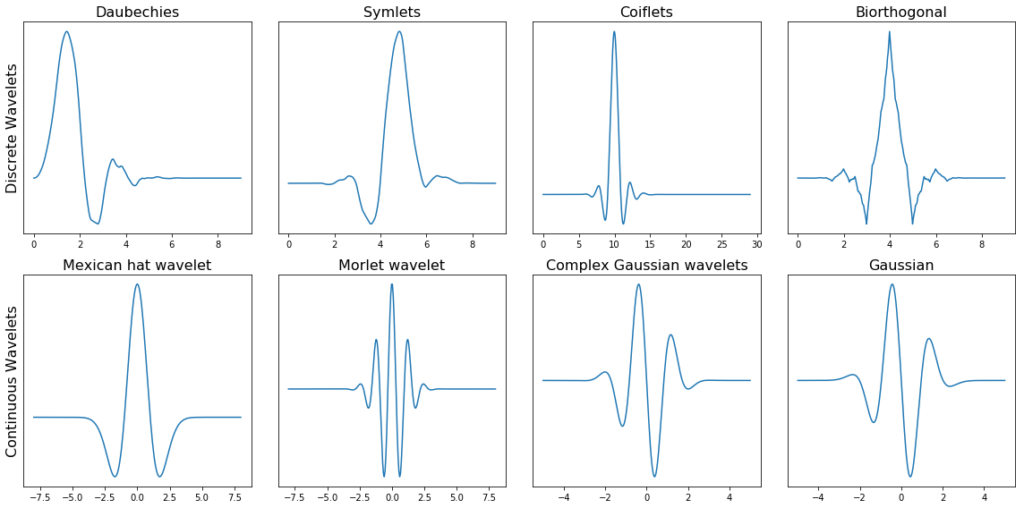

We will try different continuous wavelets because it uses all possible wavelets on a range of scales and locations unlike discrete wavelet transformation which uses a finite set of wavelets. 

In [129]:
#Time selection 
start=450 #departure time 
duration=30 #second

indices=da.indexseq(start, duration, ABP_time)

# periodogram 
frequency,power=signal.periodogram(ABP_signal[indices],fs,window='hanning',nfft=None ,scaling='density')

#Heart rate 
hr,index_hr=da.searchpeak(power,frequency,fmin=1,fmax=2)

# expected width of peaks : 
period_width=1/hr*fs

We define a vector 'period_width' corresponding to the width of the peak expected. We calculate it with $\textit{1/hr*fs}$. Let's try different wavelets.

### Ricker wavelet (Mexican hat wavelet)

Let's plot the Ricker wavelet.

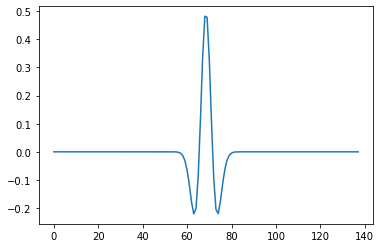

In [130]:
#plot Ricker wavelet
points = period_width
a = 3.0 #scale 
vector = signal.ricker(points, a)
plt.plot(vector)

Let's see the result on our signal.

(450.0, 460.0)

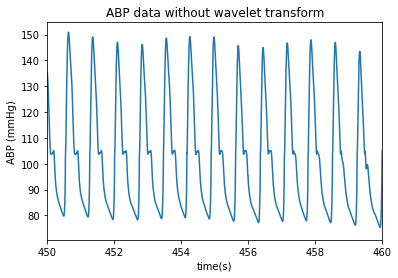

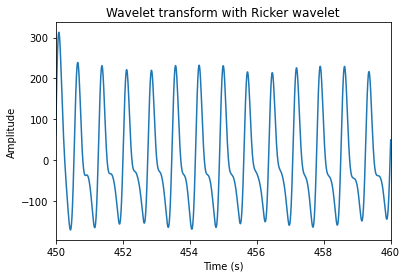

In [131]:
#wavelet transform 
width=np.ones(fs)*len(ABP_time[indices])/fs/hr
cwt=signal.cwt(data=ABP_signal[indices], wavelet=signal.ricker, widths=width)

#visualisation 
plt.plot(ABP_time[indices],ABP_signal[indices])
plt.title('ABP data without wavelet transform')
plt.ylabel('ABP (mmHg)')
plt.xlabel('time(s)')
plt.xlim([start,start+10])

plt.figure()
plt.plot(ABP_time[indices],cwt[1])
plt.title('Wavelet transform with Ricker wavelet')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim([start,start+10])

- Peak detection with Ricker wavelets transform

We try different factor to see which one is more adapted to our signal.

(450.0, 455.0)

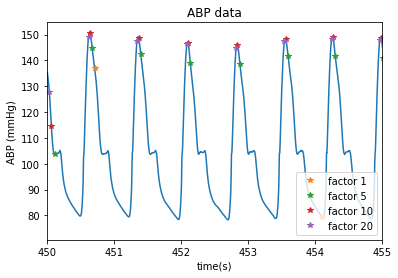

In [132]:
#peak detection 

width=np.ones(fs)*1/hr*fs #len(ABP_time[indices])/fs/hr
peaks_indices_1=signal.find_peaks_cwt(vector=ABP_signal[indices],wavelet=signal.ricker, widths=[period_width/1])
peaks_indices_5=signal.find_peaks_cwt(vector=ABP_signal[indices],wavelet=signal.ricker,widths=[period_width/5])
peaks_indices_10=signal.find_peaks_cwt(vector=ABP_signal[indices],wavelet=signal.ricker,widths=[period_width/10])
peaks_indices_20=signal.find_peaks_cwt(vector=ABP_signal[indices],wavelet=signal.ricker,widths=[period_width/20])

#visualisation of the signal with peaks detected
plt.plot(ABP_time[indices],ABP_signal[indices])
plt.plot(ABP_time[indices[peaks_indices_1]], ABP_signal[indices[peaks_indices_1]], '*',label='factor 1')
plt.plot(ABP_time[indices[peaks_indices_5]], ABP_signal[indices[peaks_indices_5]], '*',label='factor 5')
plt.plot(ABP_time[indices[peaks_indices_10]], ABP_signal[indices[peaks_indices_10]], '*',label='factor 10')
plt.plot(ABP_time[indices[peaks_indices_20]], ABP_signal[indices[peaks_indices_20]], '*',label='factor 20')

plt.legend(loc='lower right')
plt.title('ABP data')
plt.ylabel('ABP (mmHg)')
plt.xlabel('time(s)')

plt.xlim([start,start+5])

The factor 20 allows to target the sharp peaks we are looking for.

- Let's try at another time

(14985.0, 14990.0)

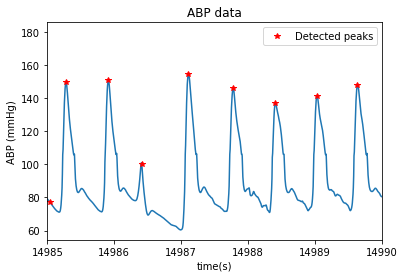

In [133]:
#Time selection 
#start=6000 #departure time 
start=14985 #departure time
duration=30 #second

indices=da.indexseq(start, duration, ABP_time)

# periodogram 
frequency,power=signal.periodogram(ABP_signal[indices],fs,window='hanning',nfft=None ,scaling='density')

#Heart rate 
#hr,index_hr=da.searchpeak(power,frequency,fmin=1,fmax=2)

#peak detection 
# expected width between peaks : 
period_width=1/hr*fs

width=np.ones(fs)*len(ABP_time[indices])/fs/hr
peaks_indices=signal.find_peaks_cwt(vector=ABP_signal[indices], widths=[period_width/20])

#visualisation of the signal with peaks detected
plt.plot(ABP_time[indices],ABP_signal[indices])
plt.plot(ABP_time[indices[peaks_indices]], ABP_signal[indices[peaks_indices]], 'r*',label='Detected peaks')

plt.legend()
plt.title('ABP data')
plt.ylabel('ABP (mmHg)')
plt.xlabel('time(s)')

plt.xlim([start,start+5])

This technique seems to work better than the first one because we are able to detect more peaks with more precision.

Let's try now with another wavelet transform.

### Morlet wavelet 

Let's plot Morlet wavelet.

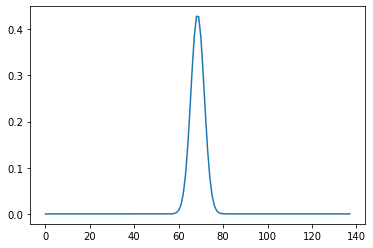

In [134]:
#plot Morlet wavelet
M = period_width #length of the wavelet 
s = 3.0 #shape of the wavelet 
w = hr #frequency 
wavelet = signal.morlet2(M, s, w)
plt.plot(abs(wavelet))

Let's see the results on our signal.

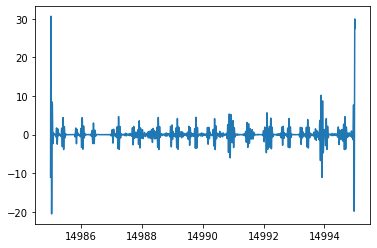

In [135]:
#Time selection 
start=14985 #departure time 
duration=10 #second
indices=da.indexseq(start, duration, ABP_time)

#wavelet transform 
width=np.ones(fs)*len(ABP_time[indices])/fs/hr
cwt=signal.cwt(data=ABP_signal[indices], wavelet=signal.morlet2, widths=width)

#visualisation 
plt.plot(ABP_time[indices],np.real(cwt[1]))

Looking through the results this wavelet does not seems adapted for our study.

# Third method 

The function 'signal.find_peaks' from scipy library. We chose a threshold of amplidute at 120 mmHg to get a maximum of peaks.

Text(0.5, 0, 'time(s)')

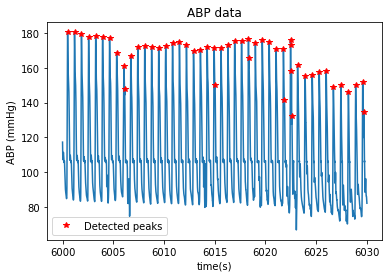

In [136]:
#Time selection 
start=6000 #departure time 
duration=30 #second

indices=da.indexseq(start, duration, ABP_time)

#peak detection 
peaks_indices, properties=signal.find_peaks(ABP_signal[indices],height=120) 

#visualisation of the signal with peaks detected
plt.plot(ABP_time[indices],ABP_signal[indices])
plt.plot(ABP_time[indices[peaks_indices]], ABP_signal[indices[peaks_indices]], 'r*',label='Detected peaks')

plt.legend()
plt.title('ABP data')
plt.ylabel('ABP (mmHg)')
plt.xlabel('time(s)')

- Let's try for another time

Text(0.5, 0, 'time(s)')

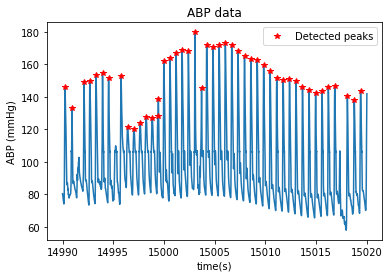

In [137]:
#Time selection 
start=14990 #departure time 
duration=30 #second

indices=da.indexseq(start, duration, ABP_time)

# periodogram 
frequency,power=signal.periodogram(ABP_signal[indices],fs,window='hanning',nfft=None ,scaling='density')

#Heart rate 
hr,index_hr=da.searchpeak(power,frequency,fmin=1,fmax=2)

#peak detection 
peaks_indices, properties=signal.find_peaks(ABP_signal[indices],height=120) 

#visualisation of the signal with peaks detected
plt.plot(ABP_time[indices],ABP_signal[indices])
plt.plot(ABP_time[indices[peaks_indices]], ABP_signal[indices[peaks_indices]], 'r*',label='Detected peaks')

plt.legend()
plt.title('ABP data')
plt.ylabel('ABP (mmHg)')
plt.xlabel('time(s)')

This method seems to also work well but some peaks are detected twice. Moreover we can't detect peaks with an amplitude lower than 120 mmHg and we can't predict the evolution of the amplitude of the signal during time.

# Fourth method 

We test the function 'signal.argrelextrema' from scipy library. 

Text(0.5, 0, 'time(s)')

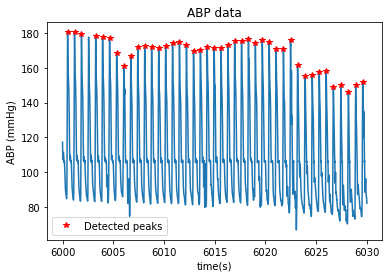

In [159]:
#Time selection 
start=6000 #departure time 
duration=30 #second

indices=da.indexseq(start, duration, ABP_time)

# periodogram 
frequency,power=signal.periodogram(ABP_signal[indices],fs,window='hanning',nfft=None ,scaling='density')

#Heart rate 
hr,index_hr=da.searchpeak(power,frequency,fmin=1,fmax=2)

#peak detection 
peaks_indices=signal.argrelextrema(ABP_signal[indices], np.greater, order=int(period_width/2)) #int(len(ABP_time[indices])/fs/hr)
#order is how many points on each side to use for the comparison to consider


#visualisation of the signal with peaks detected
plt.plot(ABP_time[indices],ABP_signal[indices])
plt.plot(ABP_time[indices[peaks_indices]], ABP_signal[indices[peaks_indices]], 'r*',label='Detected peaks')

plt.legend()
plt.title('ABP data')
plt.ylabel('ABP (mmHg)')
plt.xlabel('time(s)')

- Let's try at another time

Text(0.5, 0, 'time(s)')

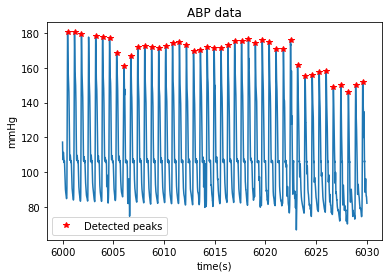

In [183]:
#Time selection 
start=6000 #departure time 
duration=30 #second

indices=da.indexseq(start, duration, ABP_time)

# periodogram 
frequency,power=signal.periodogram(ABP_signal[indices],fs,window='hanning',nfft=None ,scaling='density')

#Heart rate 
hr,index_hr=da.searchpeak(power,frequency,fmin=1,fmax=2)

#peak detection 
peaks_indices=signal.argrelextrema(ABP_signal[indices], np.greater, order=int(period_width/2)) 
#order is how many points on each side to use for the comparison to consider


#visualisation of the signal with peaks detected
plt.plot(ABP_time[indices],ABP_signal[indices])
plt.plot(ABP_time[indices[peaks_indices]], ABP_signal[indices[peaks_indices]], 'r*',label='Detected peaks')

plt.legend()
plt.title('ABP data')
plt.ylabel('mmHg')
plt.xlabel('time(s)')

This works very well. So the second and fourth methods seems appropriate. The second might be more robust against noise because it uses a wavelet filter.

But let compare the time needed to find the peak. As we have a lot of data to proceed, we may prefer to chose the fastest solution.



In [184]:
import time

t = time.process_time()
signal.find_peaks_cwt(vector=ABP_signal[indices], widths=[period_width/20])
elapsed_time_find_peaks_cwt = time.process_time() - t


t = time.process_time()
signal.argrelextrema(ABP_signal[indices], np.greater, order=int(period_width/2))
elapsed_time_argrelextrema = time.process_time() - t

print('time solution 2 :',elapsed_time_find_peaks_cwt)
print('time solution 4 :',elapsed_time_argrelextrema)

time solution 2 : 0.375
time solution 4 : 0.015625


In [185]:
elapsed_time_find_peaks_cwt/elapsed_time_argrelextrema

24.0

The solution 4 is 40 times faster than solution 2 ! So we will use this method if it seems that noise does not  lead to errors.

# Derivative 

Let's try peak detection methods for signal derivative.

- Caculation of the derivative over a period of 10 seconds.

In [163]:
#Time selection 
start=14985 #departure time 
duration=10 #second
indices=da.indexseq(start, duration, ABP_time)

#calculation of the derivative 

derivative= np.diff(ABP_signal[indices])/np.diff(ABP_time[indices])

#keep only positive derivative

derivative_pos=derivative*(derivative>0)

- Derivative visualisation 

Text(0, 0.5, 'ABP derivative (mmHg/s)')

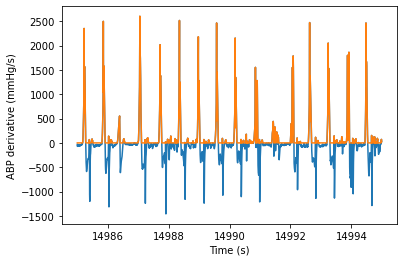

In [164]:
plt.plot(ABP_time[indices][0:-1],derivative)
plt.plot(ABP_time[indices][0:-1],derivative_pos)
plt.xlabel('Time (s)')
plt.ylabel('ABP derivative (mmHg/s)')

- Peaks detection with the second method using Ricker wavelet transform and visualisation 

(6000.0, 6010.0)

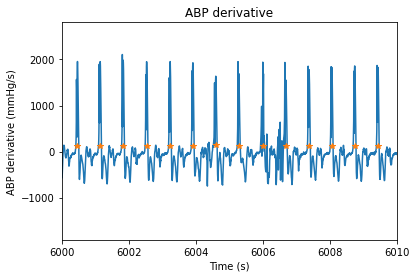

In [196]:
#calculation of the derivative 
derivative= np.diff(ABP_signal[indices])/np.diff(ABP_time[indices])

#wavelet transform 
period_width=1/hr*fs
cwt=signal.find_peaks_cwt(derivative, wavelet=signal.ricker, widths=[period_width/20])

#visualisation 
plt.plot(ABP_time[indices][0:-1],derivative)
plt.plot(ABP_time[indices[cwt]], ABP_signal[indices[cwt]], '*')
plt.title('ABP derivative')
plt.xlabel('Time (s)')
plt.ylabel('ABP derivative (mmHg/s)')
plt.xlim([start, start+10])


- Let's try with another method, fourth method

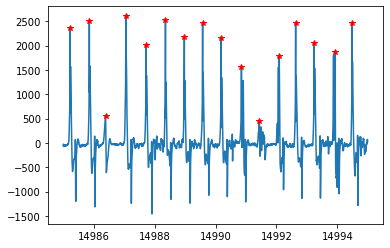

In [166]:
# periodogram 
frequency,power=signal.periodogram(derivative,fs,window='hanning',nfft=None ,scaling='density')

#Heart rate 
hr,index_hr=da.searchpeak(power,frequency,fmin=1,fmax=2)

#peak detection 
peaks_indices=signal.argrelextrema(derivative, np.greater, order=int(period_width/2)) #(len(ABP_time[indices])/fs/hr)
#order is how many points on each side to use for the comparison to considerint

#visualisation of the signal with peaks detected
plt.plot(ABP_time[indices][0:-1],derivative)
plt.plot(ABP_time[indices[peaks_indices]], derivative[peaks_indices], 'r*',label='Detected peaks')

Let's compare peaks detection with the signal and it's derivative :

(14985.0, 14990.0)

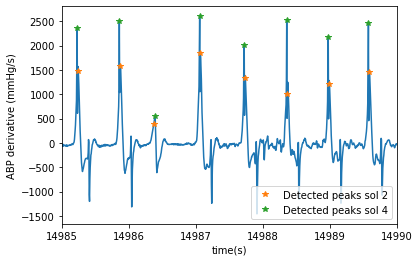

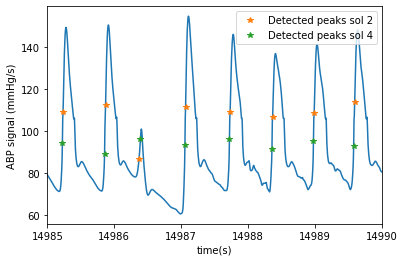

In [182]:
# periodogram 
frequency,power=signal.periodogram(derivative,fs,window='hanning',nfft=None ,scaling='density')

#Heart rate 
hr,index_hr=da.searchpeak(power,frequency,fmin=1,fmax=2)

#peak detection 
period_width=1/hr*fs
width=np.ones(fs)*len(ABP_time[indices])/fs/hr
peaks_indices_sol2=signal.find_peaks_cwt(vector=derivative, widths=[period_width/20])
peaks_indices_sol4=signal.argrelextrema(derivative, np.greater, order=int(period_width/2))

#visualisation of the signal with peaks detected
#on derivative
plt.plot(ABP_time[indices][0:-1],derivative)
plt.plot(ABP_time[indices[peaks_indices_sol2]], derivative[peaks_indices_sol2], '*',label='Detected peaks sol 2')
plt.plot(ABP_time[indices[peaks_indices_sol4]], derivative[peaks_indices_sol4], '*',label='Detected peaks sol 4')


plt.legend(loc='lower right')
plt.ylabel('ABP derivative (mmHg/s)')
plt.xlabel('time(s)')

plt.xlim([start,start+5])

#on signal
plt.figure()
plt.plot(ABP_time[indices],ABP_signal[indices])
plt.plot(ABP_time[indices[peaks_indices_sol2]], ABP_signal[indices[peaks_indices_sol2]], '*',label='Detected peaks sol 2')
plt.plot(ABP_time[indices[peaks_indices_sol4]], ABP_signal[indices[peaks_indices_sol4]], '*',label='Detected peaks sol 4')

plt.legend()
plt.ylabel('ABP signal (mmHg/s)')
plt.xlabel('time(s)')

plt.xlim([start,start+5])


Both methods seems to detect well the peaks.